In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup, ResultSet
from functools import partial
from datetime import datetime

In [9]:
class MKBag(object):

    def __init__(self):
        ## Web Options
        chrome_options = Options()
        # chrome_options.add_argument("--headless")
        self.driver = webdriver.Chrome(options=chrome_options)

    def browse_web(
        self,
        url: str = 'https://www.michaelkors.global/hk/en/women/handbags/?pmin=1.00&start=0&sz={max_item}',
        item_count: int = 50,
    ) -> ResultSet:
        self.driver.get(url.format(max_item=item_count))
        return BeautifulSoup(self.driver.page_source, 'html.parser')
    
    @staticmethod
    def extract_item_info(raw_result: ResultSet, path: str, get_item: str) -> list:
        found = raw_result.select(path)
        if not found:
            return []
        if get_item == 'text':
            return [txt.text for txt in found]
        else:
            return [item.get(get_item) for item in found]

    def item_data_constructor(self, raw_result: ResultSet) -> dict:
    
        extract_info_partial = partial(self.extract_item_info, raw_result=raw_result)
        product_link=f"https://www.michaelkors.global/{extract_info_partial(path='div.pdp-link a', get_item='href')[0]}"

        extra_details = self.get_item_details(product_link)

        basic_details = dict(
            brand=extract_info_partial(path='div.product-brand a', get_item='text'),
            item_name=extract_info_partial(path='div.pdp-link a', get_item='text')[0],
            product_link=product_link,
            product_price=extract_info_partial(path='span.default-price .value', get_item='content'),
            colors=extract_info_partial(path='div.swatches img', get_item='title'),
            product_images=extract_info_partial(path='div.image-container img', get_item='src'),
            timestamp=datetime.now()
        )

        basic_details.update(extra_details)

        return basic_details

    def get_all_bags(self) -> list:

        # total_bags = self.browse_web().select_one('span.results-count-value').text
        total_bags=10
        lst_bags = self.browse_web(item_count=total_bags).findAll('div', class_='product-tile')

        return [
            self.item_data_constructor(bags)
            for bags in lst_bags
        ]
    
    def get_item_details(self, product_link: str) -> dict:
        raw_product_detail = self.browse_web(product_link)

        extra_data = dict(
            desceiption=raw_product_detail.select('div.col-12.value.content')[0].text.strip(),
            availability=raw_product_detail.select('div.availability')[0].get('data-available')
        )

        return extra_data


        

[{'brand': ['MICHAEL Michael Kors'],
  'item_name': 'Ruthie Large Pebbled Leather Satchel',
  'product_link': 'https://www.michaelkors.global//hk/en/ruthie-large-pebbled-leather-satchel/30S4G9RS3T.html?astc=true',
  'product_price': ['3400.00'],
  'colors': [],
  'product_images': ['https://michaelkors.scene7.com/is/image/MichaelKors/30S4G9RS3T-0001_1?$medium$',
   '',
   ''],
  'timestamp': datetime.datetime(2024, 8, 10, 3, 55, 19, 415568),
  'desceiption': '\n        Designed to hold a day’s worth of essentials, our large Ruthie satchel features a mélange of polished and pragmatic elements in an effortlessly chic package. Crafted from pebbled leather with smooth trim, it’s designed in a structured silhouette that rests on gold-tone studs for sophisticated appeal. Carry it by the sleek top-handles, or wear it cross-body when you’re on the go.\n    ',
  'availability': 'true'},
 {'brand': ['MICHAEL Michael Kors'],
  'item_name': 'Ruthie Large Signature Logo Satchel',
  'product_link': 
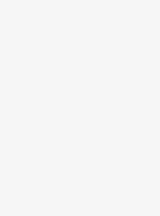
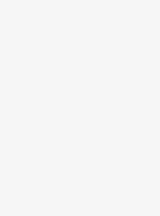
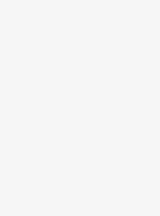
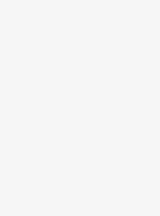
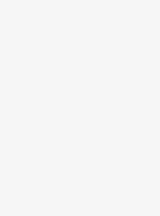
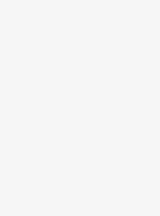
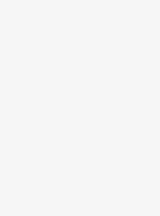
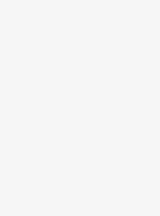
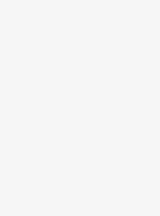
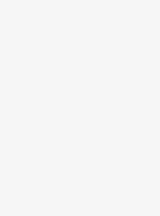
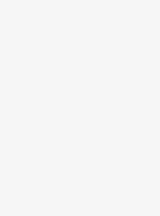
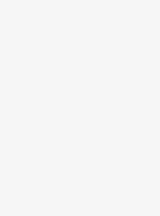
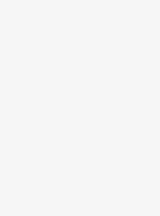
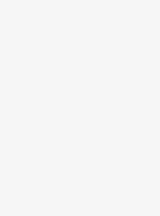
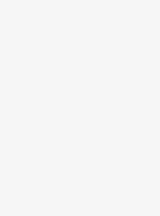
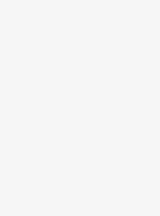
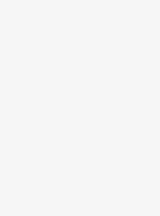
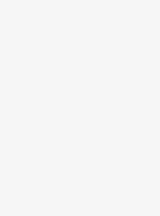
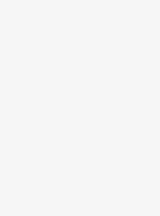
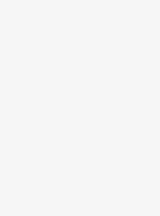
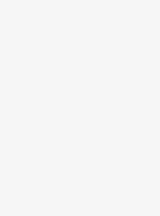
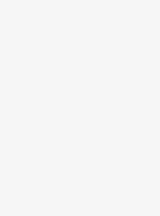
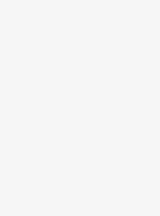
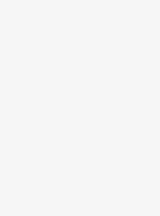
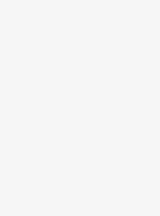
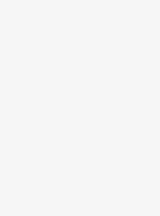
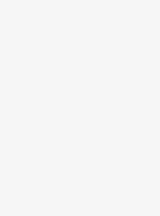
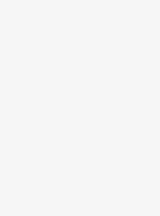
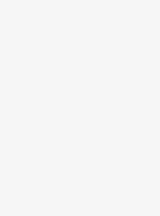
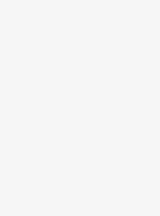

In [10]:
mk_obj = MKBag()
mk_obj.get_all_bags()

In [12]:
test_itm = mk_obj.browse_web('https://www.michaelkors.global//hk/en/jet-set-travel-large-signature-logo-messenger-bag/35S4GTVM7B.html?astc=true')
test_itm

<html lang="en" style="--webchat-adjusted-space: 100px; --header-height: 160px;"><head><meta content="A/kargTFyk8MR5ueravczef/wIlTkbVk1qXQesp39nV+xNECPdLBVeYffxrM8TmZT6RArWGQVCJ0LRivD7glcAUAAACQeyJvcmlnaW4iOiJodHRwczovL2dvb2dsZS5jb206NDQzIiwiZmVhdHVyZSI6IkRpc2FibGVUaGlyZFBhcnR5U3RvcmFnZVBhcnRpdGlvbmluZzIiLCJleHBpcnkiOjE3NDIzNDIzOTksImlzU3ViZG9tYWluIjp0cnVlLCJpc1RoaXJkUGFydHkiOnRydWV9" http-equiv="origin-trial"/><style type="text/css">@keyframes atNodeInserted231 {from {opacity:0.99} to {opacity:1}}
@-moz-keyframes atNodeInserted231 {from {opacity:0.99} to {opacity:1}}
@-webkit-keyframes atNodeInserted231 {from {opacity:0.99} to {opacity:1}}
@-ms-keyframes atNodeInserted231 {from {opacity:0.99} to {opacity:1}}
@-o-keyframes atNodeInserted231 {from {opacity:0.99} to {opacity:1}}
form[name='contact-us']{
animation-duration:0.001s;animation-name:atNodeInserted231;
-moz-animation-duration:0.001s;-moz-animation-name:atNodeInserted231;
-webkit-animation-duration:0.001s;-webkit-animation-name:

In [47]:
test_itm.select('div.col-12.value.content')[0].text
test_itm.select('div.availability')[0].get('data-available')

'false'

In [29]:
test_itm2 = mk_obj.browse_web('https://www.michaelkors.global//hk/en/ruthie-large-pebbled-leather-satchel/30S4G9RS3T.html?astc=true')
test_itm2

<html lang="en" style="--webchat-adjusted-space: 100px; --header-height: 160px;"><head><style type="text/css">@keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-moz-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-webkit-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-ms-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-o-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
form[name='contact-us']{
animation-duration:0.001s;animation-name:atNodeInserted628;
-moz-animation-duration:0.001s;-moz-animation-name:atNodeInserted628;
-webkit-animation-duration:0.001s;-webkit-animation-name:atNodeInserted628;
-ms-animation-duration:0.001s;-ms-animation-name:atNodeInserted628;
-o-animation-duration:0.001s;-o-animation-name:atNodeInserted628;
}</style><meta content="A/kargTFyk8MR5ueravczef/wIlTkbVk1qXQesp39nV+xNECPdLBVeYffxrM8TmZT6RArWGQVCJ0LRivD7glcAUAAACQeyJvcmlnaW4iOiJodHRwczovL2dvb2dsZS5jb206NDQzIiwiZmVhdHVyZSI

In [66]:
test_itm2.select('div.col-sm-12.col-md-8.col-lg-12.value.content')[0].text.strip().split('\n')


['• Satchel',
 '• Pebbled leather',
 '• 100% leather',
 '• Gold-tone hardware',
 '• 13.75”W X 9.75”H X 4.25”D',
 '• Handle drop: 4.25”',
 '• Adjustable strap: 18.5”-22.5”',
 '• Interior details: center zip compartment',
 '• Lining: 100% polyester',
 '• Snap fastening',
 '• Dust bag not included',
 '• Imported',
 '        ',
 '        • Style #',
 '        30S4G9RS3T']

In [ ]:
test_itm2 = mk_obj.browse_web('https://www.michaelkors.global//hk/en/ruthie-large-pebbled-leather-satchel/30S4G9RS3T.html?astc=true')
test_itm2

<html lang="en" style="--webchat-adjusted-space: 100px; --header-height: 160px;"><head><style type="text/css">@keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-moz-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-webkit-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-ms-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
@-o-keyframes atNodeInserted628 {from {opacity:0.99} to {opacity:1}}
form[name='contact-us']{
animation-duration:0.001s;animation-name:atNodeInserted628;
-moz-animation-duration:0.001s;-moz-animation-name:atNodeInserted628;
-webkit-animation-duration:0.001s;-webkit-animation-name:atNodeInserted628;
-ms-animation-duration:0.001s;-ms-animation-name:atNodeInserted628;
-o-animation-duration:0.001s;-o-animation-name:atNodeInserted628;
}</style><meta content="A/kargTFyk8MR5ueravczef/wIlTkbVk1qXQesp39nV+xNECPdLBVeYffxrM8TmZT6RArWGQVCJ0LRivD7glcAUAAACQeyJvcmlnaW4iOiJodHRwczovL2dvb2dsZS5jb206NDQzIiwiZmVhdHVyZSI